# CNN-LSTM

RNN архитектуры

В этой домашке будем разбираться с RNN и учиться работать со статьями, я нашла для вас вот такую достаточно уже старую, но при этом несложно написанную, статью с хорошо описанными экспериментами, в современных реалиях, она конечно не state of the art, но она хорошо подойдет для наших целей.

прочитайте статью https://arxiv.org/pdf/1511.08630.pdf
мы будем ставить эксперименты на других данных, поэтому, проанализируйте и сделайте препроцессинг на основании вашего анализа и того дизайна экспериментов, который описан в статье, для этого датасета https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv

Задача: предсказать категорию новости (там есть дополнительная колонка, не обращаем внимание, что это датасет fakenews, в этом дз нас интересует тематика новости) 

3) реализуйте на pytorch ту архитектуру модели, которую в итоге тестировали авторы (подробное описание есть в статье), таким образом, чтобы это был пайплайн для проведения экспериментов: можно было запускать модель с разными гиперпараметрами, разными способами регуляризации, описанными в статье (в том числе, чтобы можно было вставлять ее в разных местах), паддингом, векторизацией.

4) поставьте эксперименты с разными параметрами и особенностями архитектуры (регуляризация, паддинг, векторизация, драпаут и тд, в статье подробно описан смысл этих операций и что конкретно делали, загуглите как это имплементировано в торче) так как описано в статье (там есть подробное описание в разделе 5.2 Experimental Settings ) 

5) оцените результаты экспериментов также, как это сделали в статье 

6) напишите выводы (это должно быть похоже на раздел Results and Model Analysis только не нужно сравнивать с другими моделями, как это делают авторы статьи, сравнивайте только результаты своих экспериментов, потому что там цифры на других датасетах. Да писать так много тоже не нужно, но у вас и должно получиться меньше потому что не будет сравнения)

Если вы хотите дополнительный балл:

- реализуйте классы для RNN, LSTM и GRU ячейки
- реализуйте класс RNN слоя
- Если вы хотите еще один дополнительный балл, то используйте в экспериментах не RNN слой из торча, а свой самочинный слой, с разными типами ячеек (то есть поставьте дополнительные эксперименты не только с LSTM слоем, но и с обычным RNN и GRU слоем)

## Key points of the paper


1. pre-trained word vectors from massive unlabeled text data
2. one-layer CNN turn n-grams into sequential window features
3. LSTM
4. Soft-max

Loss function – Cross-entropy
Optimiser - RMSprop

! No fully connected layers between CNN and LSTM

! No pooling


***Input processing:*** 
- lowercase
- maxlen over the whole training set. In test set we cut longer sentences
- Pad with UNK token. 

***Vetor initialization:*** word2vec vectors that are pre-trained using about 100B words from the Google News Dataset. The dimensionality of the word vectors is 300. We also initialize the word vector for the unknown words from the uniform distribution [-0.25, 0.25]. Not frozen!

***Regularisation:*** 
- dropout (either to word vectors before feeding the sequence of words into the convolutional layer or to the output of LSTM before the softmax layer) 
- L2 weight regularization (the weight of the softmax layer)


***Configs***

- filter lengths of 2, 3 and 4
- single convolutional layer with the same filter length
- multiple convolu- tional layers with different lengths of filters in parallel
- since the number of windows generated from each convolution layer varies when the filter length varies, we cut the window sequence at the end based on the maximum filter length that gives the shortest number of windows.


***Hyperparameters***


For SST, the number of filters of length 3 is set to be 150 and the memory dimension of LSTM is set to be 150, too. The word vector layer and the LSTM layer are dropped out with a probability of 0.5. For TREC, the number of filters is set to be 300 and the memory dimension is set to be 300. The word vec- tor layer and the LSTM layer are dropped out with a probability of 0.5. We also add L2 regularization with a factor of 0.001 to the weights in the softmax layer for both tasks.

In [1]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [2]:
import pandas as pd
import numpy as np
from torch.optim import RMSprop
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from string import punctuation
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from tqdm.auto import tqdm
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('../input/fakecsv/Fake.csv')

In [4]:
df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [5]:
def preprocess(text):
    text = text.lower()
    text = word_tokenize(text)
    return text

In [6]:
df['preprocessed_text'] = df['text'].apply(lambda x: preprocess(x))

In [7]:
df['target'] = df['subject'].astype('category').cat.codes

In [8]:
df['target'].unique()

array([2, 5, 0, 4, 3, 1], dtype=int8)

По графику ниже видно, что у нас ужасный дисбаланс классов. Для того, чтобы его пофиксить можно было бы

1. Выбросить часть данных, чтобы приравнять число примеров по классам. Но это плохая идея, потому что сетка со свертками быстро переобучается, ей надо много данных

2. Умнее поменять лосс функцию на Focal Cross Entropy, потому что она фокусируется на выучивании "сложных" классов. Но в статье просто Cross Entropy, поэтому, видимо, мы не должны ни с чем бороться

<AxesSubplot:>

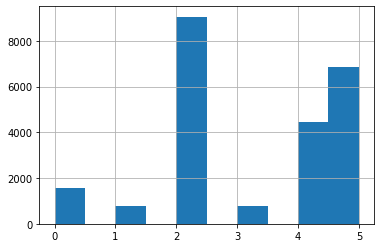

In [9]:
df['target'].hist()

In [10]:
set_random_seed(42)
all_data = shuffle(df[['preprocessed_text', 'target']])
train_sentences, test_sentences = train_test_split(all_data, test_size=0.2)

In [11]:
vocab = Counter()
for line in tqdm(all_data.preprocessed_text):
    vocab.update(line)

  0%|          | 0/23481 [00:00<?, ?it/s]

In [12]:
len(vocab.keys())

181384

In [13]:
filtered_vocab = set()

for word in vocab.keys():
    if vocab[word] > 3:
        filtered_vocab.add(word)

In [14]:
len(filtered_vocab)

48324

In [15]:
word2id = {'UNK': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

В статье написано, что авторы используют максимальную длину предложения из трейна, ниже закомменченая строка как ее посчитать. Дело в том, что максимальная длина это больше 6000 токенов, она не влезает в гпу колаба даже с батчом 32 при обучении, поэтому я для ДЗ поставила маленькую длину последовательности

In [16]:
# MAX_LEN = max([len(line) for line in train_sentences['preprocessed_text'].tolist()])
MAX_LEN = 500

In [17]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-14 08:02:12--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.102.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.102.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  19.7MB/s    in 82s     

2021-12-14 08:03:35 (19.1 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [18]:
import gensim

# Вставьте сюда путь до модели с В2В векторами
google_news_path = "GoogleNews-vectors-negative300.bin.gz"
w2v = gensim.models.KeyedVectors.load_word2vec_format(google_news_path, binary=True)

In [19]:
weights = np.zeros((len(word2id), 300))
for word, i in word2id.items(): 
    try:
        weights[i] = w2v[word]    
    except KeyError:
      # незнакомым словам + паддингу сопоставляем случайный вектор
        weights[i] = np.random.uniform(-0.25, 0.25, 300)

In [20]:
class MyDataset(Dataset):

    def __init__(self, dataset, word2id, DEVICE):
        self.dataset = dataset['preprocessed_text'].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.target = torch.Tensor(dataset['target'].values)
        self.device = DEVICE

    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        tokens = self.dataset[index] 
        ids = torch.LongTensor([self.word2id[token] if token in self.word2id \
                                else self.word2id['UNK'] for token in tokens][:MAX_LEN])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch): 
        ids, y = list(zip(*batch))
        padded_ids = torch.LongTensor(torch.stack([F.pad(idx, (1, MAX_LEN - len(idx))) for idx in ids], dim=0)).to(self.device)
        y = torch.LongTensor(y).view(len(y)).to(self.device)
        return padded_ids, y

In [21]:
DEVICE = 'cuda'

Даталоадер для трейна

In [22]:
set_random_seed(42)
train_dataset = MyDataset(train_sentences, word2id, DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=128)

Даталоадер для теста

In [23]:
set_random_seed(42)
test_dataset = MyDataset(test_sentences, word2id, DEVICE)
test_sampler = SequentialSampler(test_dataset)
test_iterator = DataLoader(test_dataset, collate_fn = test_dataset.collate_fn, sampler=test_sampler, batch_size=128)

In [24]:
import numpy as np


# Я нашла код на тензорфлоу тут https://github.com/KifayatMsd/C-LSTM-text-classification/blob/master/clstm_classifier.py
class CNN_LSTM(nn.Module):
    """
    A CNN-LSTM classifier for text classification
    Reference: A C-LSTM Neural Network for Text Classification
    """

    def __init__(self, drop_first, max_length, filter_sizes, vocab_size):
        super().__init__()
        self.drop_first = drop_first  # Флажок, который показывает, делается ли дропаут первым или последним
        self.max_length = max_length  # Максимальная длина последовательности
        self.vocab_size = vocab_size  # Размер словаря
        self.filter_sizes = filter_sizes  # Список размеров фильтров

        self.embedding = nn.Embedding(vocab_size, 300)
        self.embedding.from_pretrained(torch.tensor(weights))  # Не замороженные импортированные веса
        
        # Список сверток
        self.conv2 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=2)
        self.conv3 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=3)
        self.conv4 = nn.Conv1d(in_channels=300, out_channels=150, kernel_size=4)
        
        # Кладем в словарь нужные нам свертки
        self.convdict = {2 : self.conv2, 3 : self.conv3, 4 : self.conv4}
        

        self.lstm = nn.LSTM(input_size=150, hidden_size=150, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(p=0.5)
            
        # Активация и классификатор    
        self.relu = nn.ReLU()
        self.out = nn.Softmax(dim=1)
        self.linear = nn.Linear(150, 6)

    def forward(self, word):
        # batch_size x seq_len
        embedded = self.embedding(word)
        if self.drop_first:
            embedded = self.dropout(embedded)
        # batch_size x seq_len x embedding_dim
        embedded = embedded.transpose(1, 2)
        # batch_size x embedding_dim x seq_len

        max_feature_length = self.max_length - max(self.filter_sizes) + 1  # Обрезка по минимальной длине свертки
        conv_outputs = []
        for size in self.filter_sizes:
            layer = self.convdict[size]
            layer = layer(embedded)
            h = self.relu(layer)
            # Обрезка по последней размерности (длине аутпута)
            h = h[:, :, :max_feature_length]
            conv_outputs.append(h)
        if len(self.filter_sizes) > 1: # Если больше одной свертки, то конкатенируем, иначе возвращаем для одной свертки
            rnn_inputs = torch.cat(conv_outputs, -1)
        else:
            rnn_inputs = h
            
        # Прогоняем через ЛСТМ и классифицируем
        _, (hidden_state, _) = self.lstm(rnn_inputs.transpose(1, 2))
        if self.drop_first:
            embedded = self.dropout(embedded)
        logits = self.out(self.linear(torch.squeeze(hidden_state, 0)))
        
        return logits 

In [25]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs):
    set_random_seed(142)

    losses = []  # Лоссы по всем батчам трейна
    val_losses = [] # Лоссы по всем батчам теста
    val_losses_epoch = [] # Средний лосс эпохи теста
    val_acc = [] # Доля верных ответов по всем батчам теста
    val_acc_epoch = [] # Средняя доля верных ответов на эпохе теста

    print('Training ... ')
    for n_epoch in range(epochs):

        try:

            progress_bar = tqdm(total=len(train_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='green')
            model.train()
            for x, y in train_loader:

                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()  # считаем градиенты  
                optimizer.step()
                losses.append(loss.item())
                
                progress_bar.set_postfix(loss=np.mean(losses[-100:]))

                progress_bar.update(x.shape[0])

            progress_bar.close()


            if (n_epoch + 1) % 1 == 0:
                print('Validating ... ')
                progress_bar = tqdm(total=len(val_loader.dataset), desc='Epoch {}'.format(n_epoch + 1), colour='blue')
                val_loss = 0
                epoch_metric = 0
                model.eval() 
                with torch.no_grad():
                    for i, (texts, ys) in enumerate(val_loader):   
                        preds = model(texts)  # делаем предсказания на тесте
                        count_loss = criterion(preds, ys)   # считаем значения функции ошибки для статистики  
                        val_acc.append(accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy()))
                        epoch_metric += accuracy_score(torch.argmax(preds, dim=1).cpu().detach().numpy(), \
                                               ys.cpu().detach().numpy())
                        val_losses.append(count_loss.item())
                        val_loss += count_loss.item()
                        progress_bar.set_postfix(accuracy=np.mean(val_acc[-10:]), loss=np.mean(val_losses[-10:]))
                        progress_bar.update(texts.shape[0])
                val_acc_epoch.append(epoch_metric / len(val_loader))
                val_losses_epoch.append(val_loss / len(val_loader)) 
                progress_bar.close()
                if n_epoch + 1 < epochs:
                    print('Training ... ')
        except KeyboardInterrupt:

            progress_bar.close()
            break
    return losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch

Я обучала модели на Кэгле потому что он не вылетает как колаб, при сохранении удалился красивый вывод процесса обучения(( Выглядел так:


<img src="train_img.png" width=500 height=500 />

In [26]:
set_random_seed(42)
filter_variations = [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]

models_performance = [] # (val_acc, filters, drop)
best_acc = 0
best_train_process = []
best_filter = 0
best_drop = 0

for filters in filter_variations:
    for drop in [0, 1]: 
        print('Training new model: filter=' + str(filters) + ', drop=' + str(drop))
        model = CNN_LSTM(drop, MAX_LEN, filters, len(word2id)) #drop_first, max_length, filter_sizes, vocab_size
        model = model.to(DEVICE)
        optimizer = RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
        criterion = nn.CrossEntropyLoss()
        criterion = criterion.to(DEVICE)
        losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch = train(model, train_iterator, test_iterator, optimizer, criterion, 10)
        models_performance.append((val_acc[-1], str(filters), str(drop)))
        if val_acc[-1] > best_acc:
            best_acc = val_acc[-1]
            best_train_process = (losses, val_losses, val_losses_epoch, val_acc, val_acc_epoch)
            best_model = model
            best_filter = filters
            best_drop = drop

Training new model: filter=[2], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[3], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[3], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[4], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[4], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 3], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 3], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[3, 4], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[3, 4], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 4], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 4], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 3, 4], drop=0
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

Training new model: filter=[2, 3, 4], drop=1
Training ... 


Epoch 1:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 1:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 2:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 2:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 3:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 3:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 4:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 4:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 5:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 5:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 6:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 6:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 7:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 7:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 8:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 8:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 9:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 9:   0%|          | 0/4697 [00:00<?, ?it/s]

Training ... 


Epoch 10:   0%|          | 0/18784 [00:00<?, ?it/s]

Validating ... 


Epoch 10:   0%|          | 0/4697 [00:00<?, ?it/s]

In [27]:
models_performance  # Качество по моделям с параметрами

[(0.6404494382022472, '[2]', '0'),
 (0.6292134831460674, '[2]', '1'),
 (0.6179775280898876, '[3]', '0'),
 (0.6404494382022472, '[3]', '1'),
 (0.6404494382022472, '[4]', '0'),
 (0.6067415730337079, '[4]', '1'),
 (0.6292134831460674, '[2, 3]', '0'),
 (0.5955056179775281, '[2, 3]', '1'),
 (0.6292134831460674, '[3, 4]', '0'),
 (0.6179775280898876, '[3, 4]', '1'),
 (0.6179775280898876, '[2, 4]', '0'),
 (0.6404494382022472, '[2, 4]', '1'),
 (0.6292134831460674, '[2, 3, 4]', '0'),
 (0.6067415730337079, '[2, 3, 4]', '1')]

In [28]:
df_performance = pd.DataFrame(models_performance, columns=['val_acc', 'filters', 'drop'])

<AxesSubplot:xlabel='filters', ylabel='val_acc'>

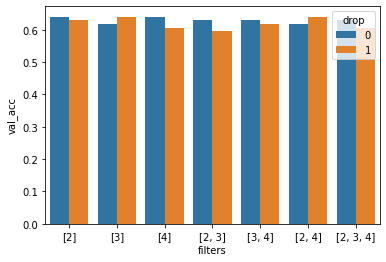

In [29]:
ax = sns.barplot(x="filters", y="val_acc", hue="drop", data=df_performance)
ax

In [30]:
print('Best accuracy:', best_acc)
print('Best filters:', best_filter)
print('Best dropout flag:', best_drop)
print('Best model:', best_model)

Best accuracy: 0.6404494382022472
Best filters: [2]
Best dropout flag: 0
Best model: CNN_LSTM(
  (embedding): Embedding(48325, 300)
  (conv2): Conv1d(300, 150, kernel_size=(2,), stride=(1,))
  (conv3): Conv1d(300, 150, kernel_size=(3,), stride=(1,))
  (conv4): Conv1d(300, 150, kernel_size=(4,), stride=(1,))
  (lstm): LSTM(150, 150, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (out): Softmax(dim=1)
  (linear): Linear(in_features=150, out_features=6, bias=True)
)


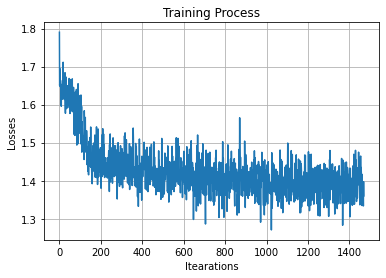

In [31]:
plt.title('Training Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(best_train_process[0])

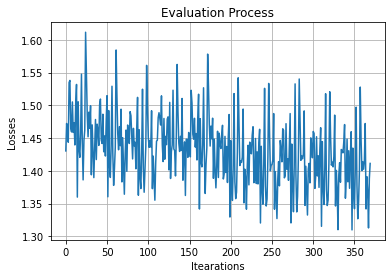

In [32]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Losses')
plt.grid()
plt.plot(best_train_process[1])

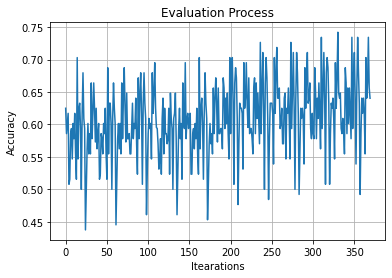

In [33]:
plt.title('Evaluation Process')
plt.xlabel('Itearations')
plt.ylabel('Accuracy')
plt.grid()
plt.plot(best_train_process[3])

In [34]:
preds = []
true = []
for i, (texts, ys) in enumerate(test_iterator):   
    preds.extend(torch.argmax(model(texts), dim=1).cpu().detach().numpy())
    true.extend(ys.cpu().detach().numpy())
    
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       320
           1       0.00      0.00      0.00       146
           2       0.69      0.97      0.81      1770
           3       0.52      0.36      0.43       151
           4       0.00      0.00      0.00       920
           5       0.50      0.76      0.60      1390

    accuracy                           0.60      4697
   macro avg       0.29      0.35      0.31      4697
weighted avg       0.42      0.60      0.50      4697



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Ну в целом как мы видим, все плохо. 2 класса не предсказываются вообще из-за дисбаланса, который мы заметили в начале. Для улучшения я бы в первую очередь поменяля лосс и оптимизацию. Поставила бы расписание на лернинг рейт, по моему выводу не видно (из-за кэгла), но некоторые модели переобучаются за 10 эпох